In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
print(stoi)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [66]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [67]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [16]:
C=torch.randn((27,2))

In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [20]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [27]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
h

tensor([[-0.2612, -0.4473,  0.7229,  ..., -0.0487, -0.2007,  0.9748],
        [-0.2136,  0.3319, -0.3941,  ..., -0.8598,  0.6223,  0.9241],
        [ 0.4517, -0.3217, -0.1097,  ..., -0.6611, -0.0132,  0.4852],
        ...,
        [-0.2309, -0.7802,  0.6692,  ..., -0.2964,  0.8582,  0.9871],
        [-0.6138,  0.8741,  0.7461,  ..., -0.6459, -0.5451,  0.9002],
        [ 0.2325, -0.9141,  0.1664,  ...,  0.2368, -0.7335,  0.9813]])

In [28]:
h.shape

torch.Size([32, 100])

In [29]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [30]:
logits = h @ W2 + b2

In [31]:
logits.shape

torch.Size([32, 27])

In [32]:
counts = logits.exp()

In [49]:
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)


torch.Size([32, 27])


In [37]:
prob[0].sum() #every row of prob is normalized 

tensor(1.0000)

In [53]:
#calculate the loss 
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.4190)

In [54]:
log_probs = F.log_softmax(logits, dim=1)  # numerically stable log-softmax
loss = -log_probs[torch.arange(32), Y].mean()
loss

tensor(17.7697)

In [42]:
# ------------ clean collective code :) ---------------

In [68]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [98]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [99]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [100]:
for p in parameters:
  p.requires_grad = True

In [101]:
#how to choose an optimal learning rate
lre = torch.linspace(-3, 0, 1000) #lre = learning rate exponent
lrs = 10**lre #actual learning rate 

In [102]:
lri =[] #learning rate between the range 
lossi = [] #losses we saw while training
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    #forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean() 
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track loss stats
    lri.append(lre[i])
    lossi.append(loss.item())


20.223434448242188
17.66786003112793
23.154401779174805
15.72214126586914
16.94044303894043
19.770666122436523
19.93256950378418
19.730758666992188
20.955598831176758
19.088932037353516
16.632057189941406
19.607229232788086
16.890501022338867
18.216604232788086
21.37424659729004
13.900766372680664
18.82939338684082
18.918153762817383
16.748815536499023
21.820659637451172
18.23989486694336
16.975770950317383
19.107467651367188
16.185070037841797
21.31393814086914
18.221046447753906
18.111675262451172
21.042987823486328
20.847068786621094
19.06575584411621
17.517333984375
17.372844696044922
17.677982330322266
18.232219696044922
19.256702423095703
16.502195358276367
20.849445343017578
16.930740356445312
18.41380500793457
18.368091583251953
17.757984161376953
18.158788681030273
14.243247032165527
19.330608367919922
20.221281051635742
17.979183197021484
14.334181785583496
19.6348876953125
18.410476684570312
17.63030242919922
20.4156551361084
18.524885177612305
18.431121826171875
17.63428497

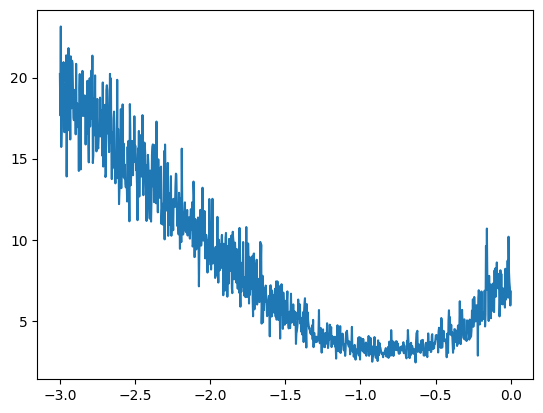

In [103]:
plt.plot(lri,lossi)